<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/L05_Power_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

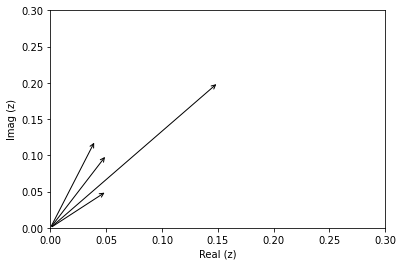

In [52]:
z =np.array([.05 + .1j, 
             .05 + .05j, 
             .15 + .2j, 
             .04 + .12j])

fig, ax = plt.subplots(1, 1)
[ax.annotate('', xy=(x.real, x.imag), xytext=(0, 0), arrowprops=dict(arrowstyle="->")) for i, x in enumerate(z)]
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.xlabel('Real (z)')
plt.ylabel('Imag (z)');

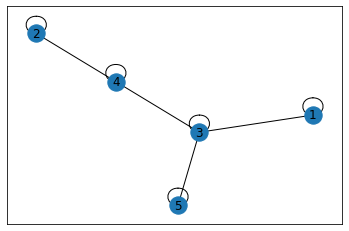

In [199]:
incidence =np.asanyarray([[1,  0,  0,  0],
            [0,  0,  0,  1],
            [-1,  1, -1,  0],
            [0,  0,  1, -1],
            [0, -1,  0,  0]], dtype=int)

incidence_abs = np.abs(incidence)
adiacency = incidence_abs @ incidence_abs.T
graph = nx.from_numpy_matrix(adiacency)
graph = nx.relabel_nodes(graph, lambda x: x+1)

positions = nx.kamada_kawai_layout(graph)
nx.draw_networkx(graph, pos=positions)

In [163]:
VNM = np.array([1.05, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)

VNA = np.array([0, 0, 0, 0, 0], dtype=bool).reshape(-1, 1)

# Creiamo un vettore che indichi quali potenziali e angoli siano da usare 
# come riferimento nella fase di controllo dell'errore
KNM = np.array([1, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
KNA = np.array([0, 0, 0, 0, 1], dtype=bool).reshape(-1, 1)

# e quali sono manipolati dal sistema
KUM = ~KNM
KUA = ~KNA

# Specifichiamo le potenze note, positive se entranti.
# Mettiamo 0 per indicare potenze non note
P = np.array([1, 1, -.9, -1, 0]).reshape(-1, 1)
Q = np.array([0, 0, 0, -.2, 0]).reshape(-1, 1)

# Creiamo un vettore che indichi quali potenze sono da usare come
# riferimento nella fase di controllo dell'errore
PC = np.array([1, 1, 1, 1, 0]).reshape(-1, 1)
QC = np.array([0, 0, 1, 1, 0]).reshape(-1, 1)

Y = np.diag(1/z)

YN = incidence_abs @  Y @ incidence_abs.T  
print(YN)

[[ 4.  -8.j   0.  +0.j   4.  -8.j   0.  +0.j   0.  +0.j ]
 [ 0.  +0.j   2.5 -7.5j  0.  +0.j   2.5 -7.5j  0.  +0.j ]
 [ 4.  -8.j   0.  +0.j  16.4-21.2j  2.4 -3.2j 10. -10.j ]
 [ 0.  +0.j   2.5 -7.5j  2.4 -3.2j  4.9-10.7j  0.  +0.j ]
 [ 0.  +0.j   0.  +0.j  10. -10.j   0.  +0.j  10. -10.j ]]


In [181]:
VM = np.array([1.05, 1, .99, .99, 1]).reshape(-1, 1)
VA = np.array([.02, .01, .01, .02, 0]).reshape(-1, 1)
Error = 1
Tol = 1e-12
N = len(VNM)
VMAG = VNM * KNM + VM * KUM
VANG = VNA * KNA + VA * KUA
V = VMAG * np.exp(1j * VANG)
r=1


In [209]:
def solve_lf(NI,YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-6):
  #Risolve il load flow monofase approssimato, noti i parametri fisici della
  #rete

  # vettori delle variabili non note
  KUM = ~KNM
  KUA = ~KNA

  # Inizializiamo l'errore 
  Error = 1
  N = len(VNM)

  # Construiamo i vettori dei potenziali combinando i valori noti e i guess
  # iniziali

  VMAG = VNM * KNM + VM * KUM
  VANG = VNA * KNA + VA * KUA

  # costruiamo il vettore complesso dei potenziali
  V = VMAG * np.exp(1j * VANG);

  # inizializziamo un contatore per tenere traccia dell'errore
  r=1;
  Errors = []

  while Error>tol:

    for i in range(N): #% risolviamo tutti i nodi
        # Il metodo risolutivo dipende dal nodo
        if (KUM[i] == 1) and (KUA[i] == 1): # se il nodo è un carico
            pvc= (P[i]-1j * Q[i]) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n]) 
            V[i] = pvc/YN[i,i]
        elif (KUM[i] == 0) and (KUA[i] == 1): # se il nodo è un generatore
            # generaiamo una nuova stima di Q
            Qn = np.imag(V[i] * np.conj(YN[[i],:] @ V))
            pvc= (P[i] - 1j * Qn) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n])
            pv=pvc/YN[i,i]
            V[i] = VM[i] @ np.exp(1j * np.angle(pv))

    # Ricalcoliamo la corrente con le soluzioni dei potenziali
    I = (YN@V)

    # Per controllare l'errore, ricalcoliamo le potenze
    PI = np.real(V * np.conj(I));
    QI = np.imag(V * np.conj(I));

    # Controlliamo che le soluzioni non contraddicano i valori noti delle
    # potenze
    PERR = (P-PI) * PC
    QERR = (Q-QI) * QC
    Error = np.sum(np.abs(PERR)**2 + np.abs(QERR)**2)
    Errors.append(Error)
    r=r+1
    if r%2==0:
      plt.figure()
      nx.set_node_attributes(graph, {k:v.real for k, v in zip(graph.nodes, np.abs(V).ravel())}, 'v')
      nx.draw_networkx(graph, node_color=list(nx.get_node_attributes(graph, 'v').values()), pos=positions)
  DVline = NI.T @ V;
  I = YN @ V
  Iline = Y @ DVline
  Sloss = DVline * np.conj(Iline)
  return V,P,Q,I,DVline,Iline,Sloss, Errors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[ 1.04507983+0.10152907j]
 [-0.98915164-0.14689806j]
 [-0.99328789-0.0073596j ]
 [ 0.94906785+0.02551937j]
 [ 1.        +0.j        ]]


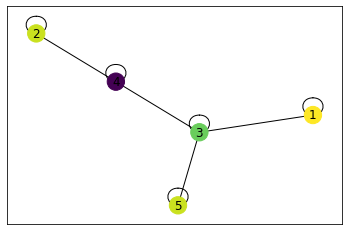

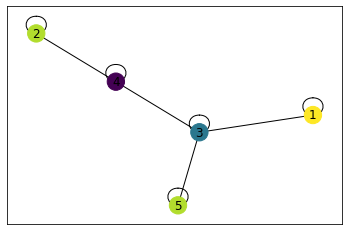

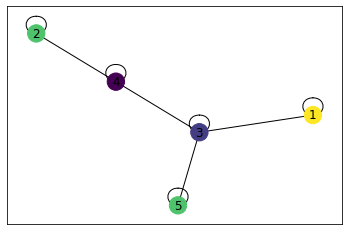

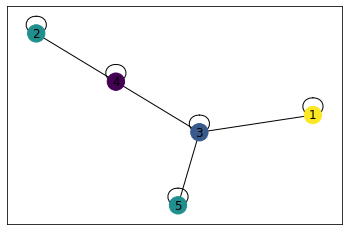

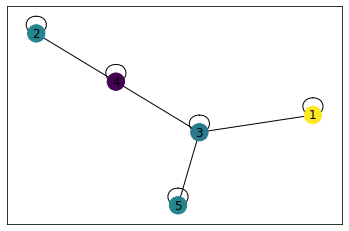

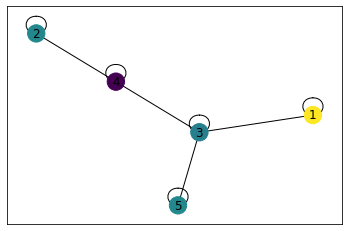

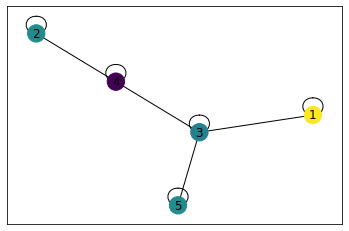

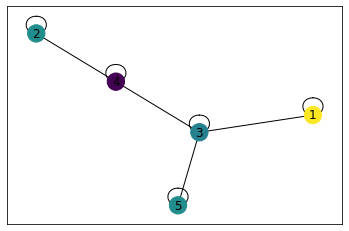

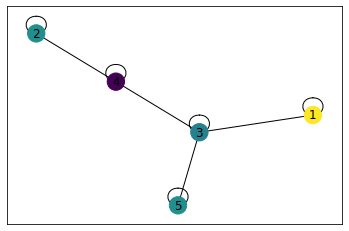

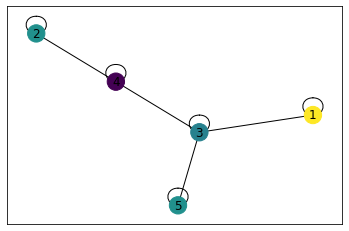

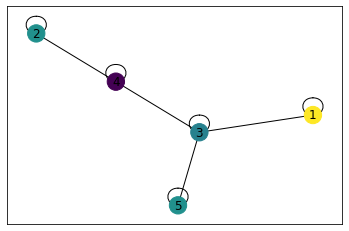

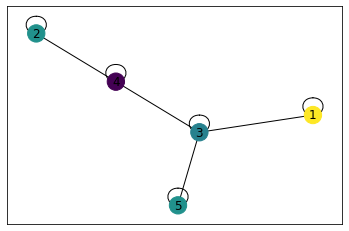

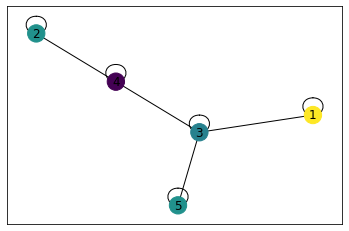

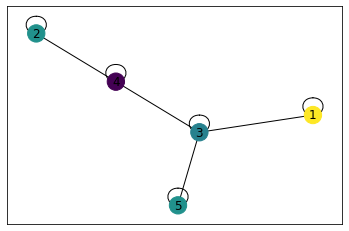

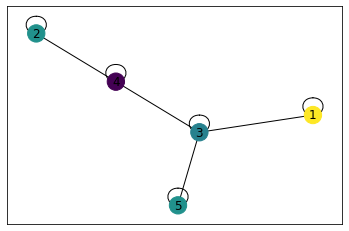

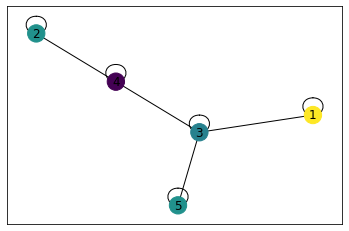

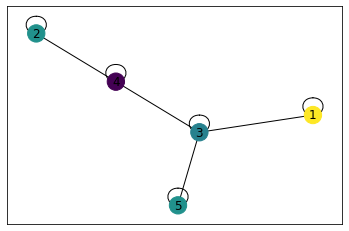

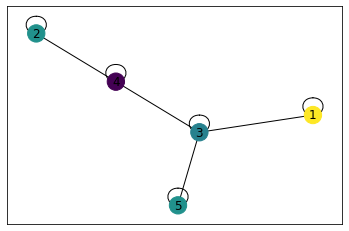

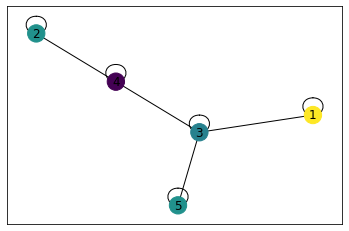

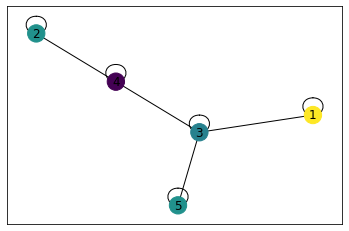

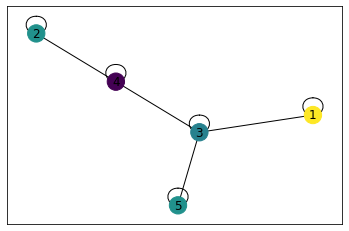

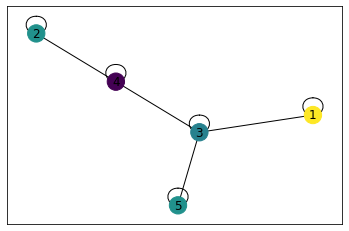

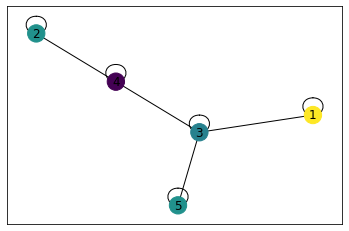

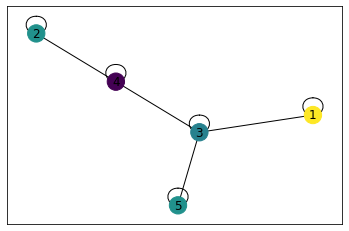

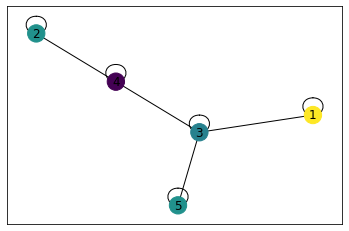

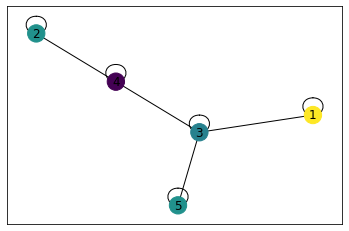

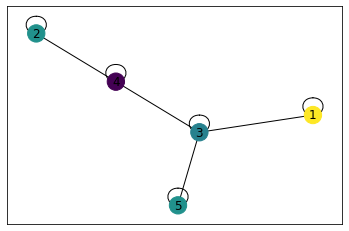

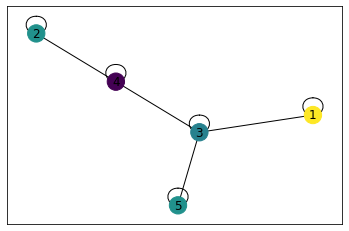

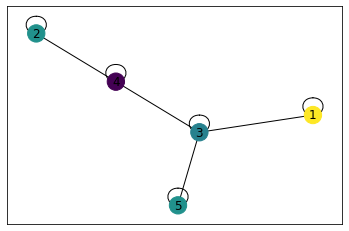

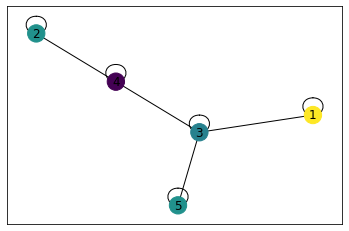

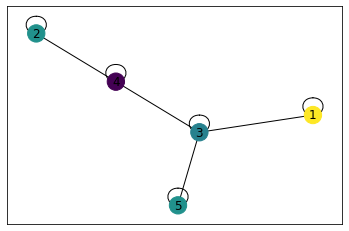

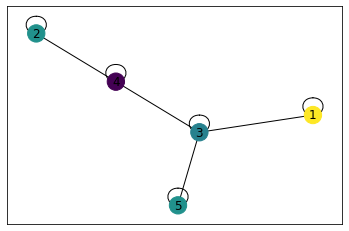

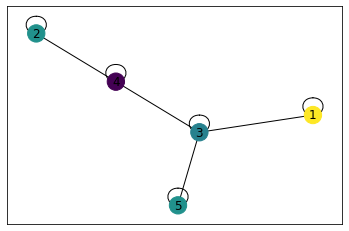

In [210]:
V,P,Q,I,DVline,Iline,Sloss, errs = solve_lf(incidence, YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-12)
print(V)

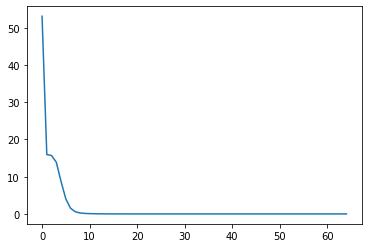

In [184]:
plt.plot(errs)

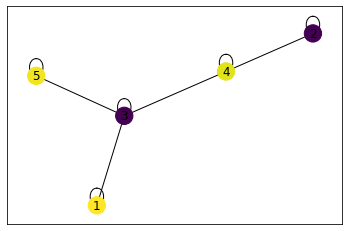

In [160]:
nx.get_node_attributes(graph, 'v')

{1: 1.0450798277699473,
 2: -0.98915163540547,
 3: -0.9932878944503755,
 4: 0.9490678456393856,
 5: 1.0}